In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.models import model_from_json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob
import datetime
import numpy as np

In [3]:
#Basic Varibales for Data
img_rows, img_cols = 80, 80
batch_size = 16
num_classes = 36

#Declaring Variables for Train and Test Data Directory
train_data_dir = './refined_dataset/train'
validation_data_dir = './refined_dataset/test'

#Data Augmentation to get all the Data in Different Mannner
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, width_shift_range=0.3, height_shift_range=0.3, horizontal_flip=False, fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)

#Lets Make Generators for getting The Data and Look at Size of dataset
train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_rows, img_cols), batch_size=batch_size, class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory(validation_data_dir,target_size=(img_rows, img_cols),batch_size=batch_size, class_mode='categorical')

Found 307063 images belonging to 36 classes.
Found 43904 images belonging to 36 classes.


In [3]:
#Create a model for Training and Testing
def create_model(lr=1e-4,decay=1e-4/25, training=False,output_shape=num_classes):
    baseModel = MobileNetV2(weights="imagenet", 
                            include_top=False,
                            input_tensor=Input(shape=(80, 80, 3)))

    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(output_shape, activation="softmax")(headModel)
    
    model = Model(inputs=baseModel.input, outputs=headModel)
    
    if training:
        # define trainable lalyer
        for layer in baseModel.layers:
            layer.trainable = True
        # compile model
        optimizer = Adam(lr=lr, decay = decay)
        model.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])    
        
    return model

# initilaize initial hyperparameter
INIT_LR = 1e-4
EPOCHS = 30

model = create_model(lr=INIT_LR, decay=INIT_LR/EPOCHS,training=True)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 40, 40, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 40, 40, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 40, 40, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [4]:
BATCH_SIZE = 64

log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'MobileNetV2_NewModel'

my_checkpointer = [
                EarlyStopping(monitor='val_loss', patience=5, verbose=1),
                ModelCheckpoint(filepath="License_character_recognition_MobileNetV2_NewModel.h5", verbose=1, save_weights_only=True, restore_best_weights = True),
                TensorBoard(log_dir=log_dir, histogram_freq=1)
                ]

#Declaring Variables for Training Samples and Testing Samples
nb_train_samples = 307063 
nb_validation_samples = 43904
epochs = 30

result = model.fit_generator(train_generator, steps_per_epoch = nb_train_samples // batch_size, epochs = epochs,callbacks = my_checkpointer,validation_data = validation_generator, validation_steps = nb_validation_samples // batch_size)

# save model architecture as json file
model_json = model.to_json()
with open("MobileNets_character_recognition_MobileNetV2_NewModel.json", "w") as json_file:
    json_file.write(model_json)

C:\Users\Majid\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
19191/19191 [==============================] - 5994s 312ms/step - loss: 1.6734 - accuracy: 0.5527 - val_loss: 0.4898 - val_accuracy: 0.8741

Epoch 00001: saving model to License_character_recognition_MobileNetV2_NewModel.h5
Epoch 2/30
19191/19191 [==============================] - 5091s 265ms/step - loss: 0.7274 - accuracy: 0.8084 - val_loss: 0.4349 - val_accuracy: 0.8843

Epoch 00002: saving model to License_character_recognition_MobileNetV2_NewModel.h5
Epoch 3/30
19191/19191 [==============================] - 5215s 272ms/step - loss: 0.6193 - accuracy: 0.8346 - val_loss: 0.4416 - val_accuracy: 0.8731

Epoch 00003: saving model to License_character_recognition_MobileNetV2_NewModel.h5
Epoch 4/30
19191/19191 [==============================] - 4918s 256ms/step - loss: 0.5654 - accuracy: 0.8497 - val_loss: 0.3576 - val_accuracy: 0.9043

Epoch 00004: saving model to License_character_recognition_MobileNetV2_NewModel.h5
Epoch 5/30
19191/19191 [==============================] - 49

In [1]:
#Imports Needed to Print Confusion Matrix
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
def load_model(path):
        try:
            path = splitext(path)[0]
            with open('%s.json' % path, 'r') as json_file:
                model_json = json_file.read()
            model = model_from_json(model_json, custom_objects={})
            model.load_weights('%s.h5' % path)
            print("Loading model successfully...")
            return model
        except Exception as e:
            print(e)

json_file = open('MobileNets_character_recognition_MobileNetV2_NewModel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("License_character_recognition_MobileNetV2_NewModel.h5")

validation_data_dir1 = './refined_dataset/val'
nb_validation_samples1 = 87724

validation_datagen1 = ImageDataGenerator(rescale=1./255)

validation_generator1 = validation_datagen1.flow_from_directory(
        validation_data_dir1,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator1, nb_validation_samples1 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print(len(y_pred))

Found 87724 images belonging to 36 classes.
87724


"\nprint('Confusion Matrix')\nprint(confusion_matrix(validation_generator.classes, y_pred))\n\nprint('Classification Report')\ntarget_names = list(class_labels.values())\nprint(classification_report(validation_generator.classes, y_pred, target_names=target_names))\n\nplt.figure(figsize=(8,8))\ncnf_matrix = confusion_matrix(validation_generator.classes, y_pred)\n\nplt.imshow(cnf_matrix, interpolation='nearest')\nplt.colorbar()\ntick_marks = np.arange(len(classes))\n_ = plt.xticks(tick_marks, classes, rotation=90)\n_ = plt.yticks(tick_marks, classes)\n"

Confusion Matrix
[[ 429    0    0 ...    0    0    0]
 [   0  434    0 ...    0    0    0]
 [   0    0  439 ...    0    0    2]
 ...
 [   0    0    0 ... 2997   37    6]
 [   0    0    0 ...   42 3014    5]
 [   0    1    1 ...   42   19 2979]]
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       452
           1       0.98      0.98      0.98       444
           2       0.99      0.99      0.99       444
           3       1.00      1.00      1.00       431
           4       1.00      0.99      0.99       428
           5       0.99      1.00      0.99       444
           6       1.00      1.00      1.00       440
           7       0.99      0.99      0.99       431
           8       1.00      0.99      1.00       431
           9       0.99      1.00      0.99       432
           A       0.92      0.92      0.92      3205
           B       0.95      0.93      0.94      3212
           C       0.95      0

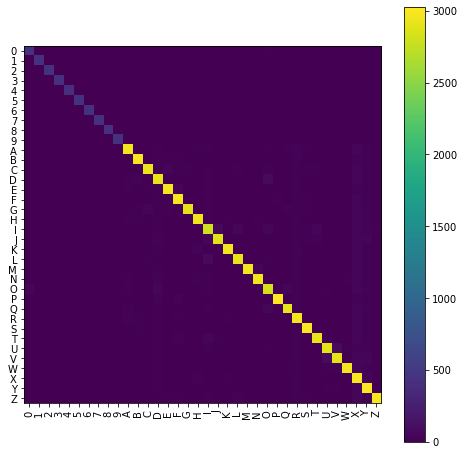

In [8]:
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)